<a href="https://colab.research.google.com/github/ryann-li/Machine-Learning-Cancer-Detection/blob/main/Potato_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
import tensorflow as tf
from keras import models, layers
import matplotlib.pyplot as plt
from google.colab import drive


In [79]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [80]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [81]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [82]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [83]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


Visualize Images


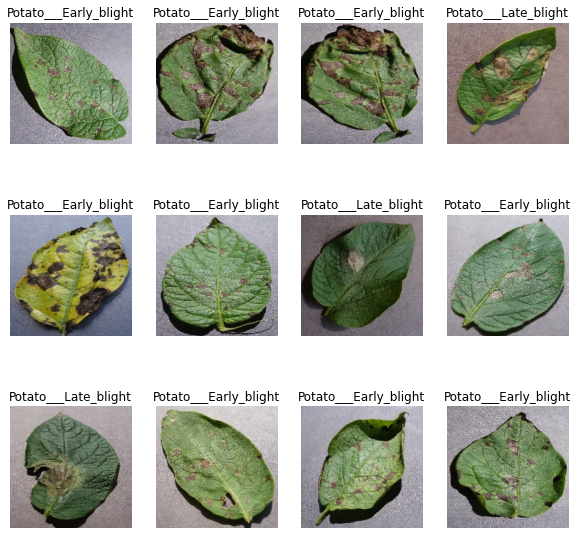

In [84]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [85]:
len(dataset)

68

In [86]:
train_size = 0.8
len(dataset) * train_size

54.400000000000006

In [87]:
train_ds = dataset.take(54)
len(train_ds)

54

In [88]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [89]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [90]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [91]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [92]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [93]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [94]:
len(train_ds)

54

In [95]:
len(val_ds)

6

In [96]:
len(test_ds)

8

Optimize using cache and prefetch

In [97]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [98]:
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
])

In [99]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

At this point, data loaded into tensorflow dataset, train test split, started preprocessing (created layers for preprocessing)

In [100]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [101]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [102]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

In [103]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [104]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 204s 4s/step - loss: 0.9121 - accuracy: 0.4786 - val_loss: 0.8837 - val_accuracy: 0.5677
Epoch 2/50
54/54 [==============================] - 187s 3s/step - loss: 0.8490 - accuracy: 0.6111 - val_loss: 0.7406 - val_accuracy: 0.6354
Epoch 3/50
54/54 [==============================] - 216s 4s/step - loss: 0.5491 - accuracy: 0.7766 - val_loss: 0.4449 - val_accuracy: 0.7917
Epoch 4/50
54/54 [==============================] - 194s 4s/step - loss: 0.2886 - accuracy: 0.8825 - val_loss: 0.4967 - val_accuracy: 0.8281
Epoch 5/50
54/54 [==============================] - 189s 3s/step - loss: 0.2144 - accuracy: 0.9126 - val_loss: 0.8263 - val_accuracy: 0.7656
Epoch 6/50
54/54 [==============================] - 197s 4s/step - loss: 0.2219 - accuracy: 0.9097 - val_loss: 0.3439 - val_accuracy: 0.8542
Epoch 7/50
54/54 [==============================] - 190s 4s/step - loss: 0.1785 - accuracy: 0.9225 - val_loss: 0.5820 - val_accuracy: 0.7865
Epoch 8/50
54

In [105]:
scores = model.evaluate(test_ds)
scores

8/8 [==============================] - 21s 2s/step - loss: 0.0991 - accuracy: 0.9727


[0.09913402795791626, 0.97265625]

In [106]:
history

In [107]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [108]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [109]:
type(history.history['loss'])

list

In [110]:
len(history.history['loss'])

50

In [111]:
history.history['loss'][:5]

[0.9121361374855042,
 0.8490297794342041,
 0.5490999817848206,
 0.28856319189071655,
 0.21438023447990417]

In [112]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

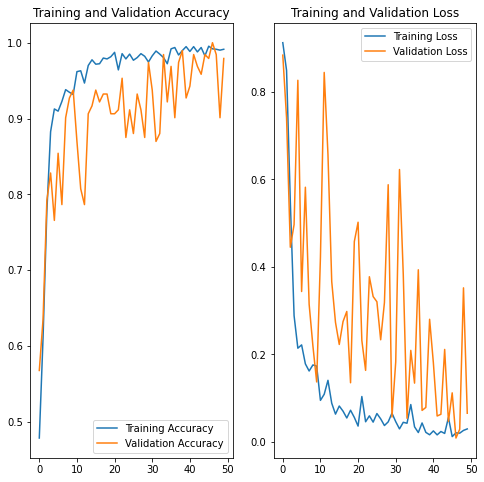

In [113]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Run prediction on a sample image

first image to predict
actual label: Potato___Early_blight
predicted label: Potato___Early_blight


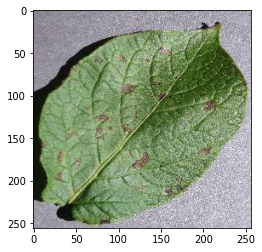

In [114]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

Write a function for inference

In [115]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

Now run inference on few sample images

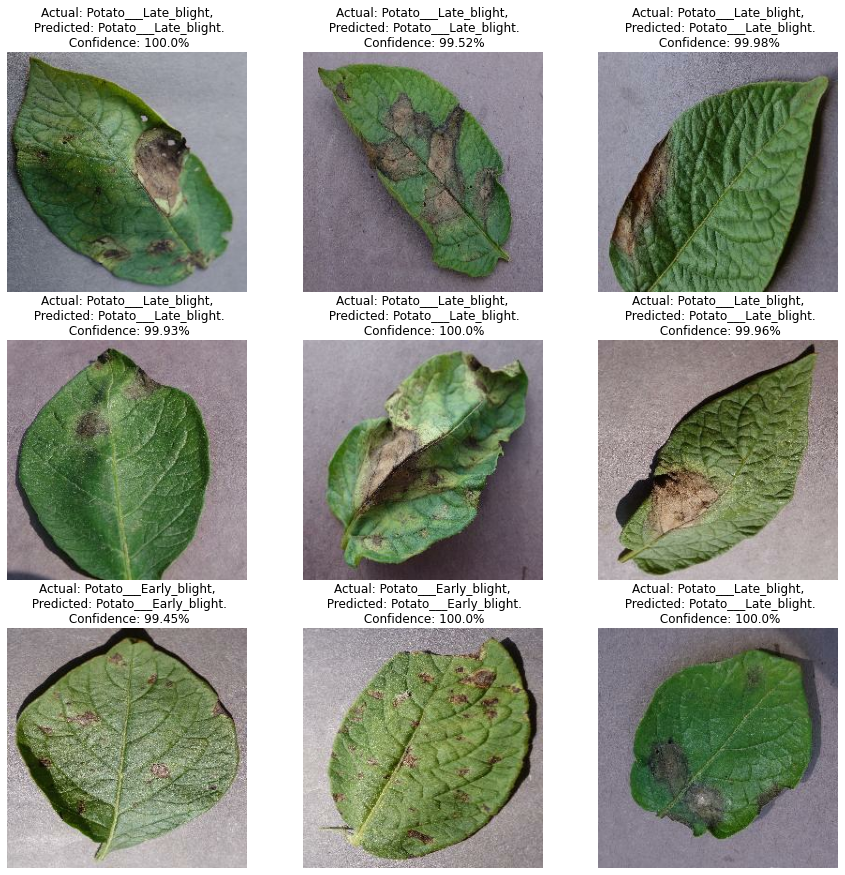

In [116]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

Saving the Model
We append the model to the list of models as a new version

In [126]:


model.save("potato-disease-model3.h5")



In [ ]:
/content/potato-disease-model.h5